# Segmenting and Clustering Neighborhoods

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
import requests
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

# my foursquare credentials
import foursquare_id as login

## Fetch wikipedia data

Read data and remove 'not assigned' boroughs

In [2]:
toronto = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
toronto = toronto[toronto['Borough'] != 'Not assigned']
print('Downloaded data and removed not assigned boroughs')

Downloaded data and removed not assigned boroughs


Data frame already seems to have neighborhoods separted by commas for same the postal code, but check for duplicate postal codes just in case

In [3]:
duplicates = sum(toronto.duplicated())
print('Data frame has',duplicates,'postal codes listed more than once')

Data frame has 0 postal codes listed more than once


Label any 'not assigned' neighbourhoods with borough name

In [4]:
n_index = toronto['Neighbourhood'] == 'Not assigned'
toronto.loc[n_index,'Neighbourhood'] = toronto.loc[n_index,'Borough']
toronto.reset_index(inplace=True, drop=True)
print('Toronto data frame cleaned')
toronto

Toronto data frame cleaned


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Size of data frame

In [5]:
toronto.shape

(103, 3)

## Get latitude and longitude of locations

I kept getting "request denied" outputs with the Geocoder package, so I am loading in latitude and longtitude values from the csv file

In [6]:
# fetch coordinates
lat_lng_coords = pd.read_csv('http://cocl.us/Geospatial_data')

Merge coordinates with my toronto neighborhoods dataframe

In [7]:
toronto_coords = toronto.merge(lat_lng_coords, on="Postal Code")
toronto_coords

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Cluster Neighborhoods

Filter by boroughs containing "Toronto"

In [8]:
toronto_data = toronto_coords[toronto_coords['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Plot a map of Toronto neighborhoods

In [9]:
t_lat = 43.6532
t_lng = -79.3832

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[t_lat, t_lng], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#0083B0',
        fill=True,
        fill_color='#00B4DB',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Get my foursquare credentials and define parameters for url:

In [10]:
# stored in file foursquare_id.py (gitignored) to avoid showing here

CLIENT_ID = login.foursquare['accessID'] # your Foursquare ID
CLIENT_SECRET = login.foursquare['secretID'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
QUERY = "restaurant"

What kinds of restaurants are within 1km of each of my neighborhoods?

In [11]:
venues_list=[]
for name, lat, lng in zip(toronto_data['Postal Code'], toronto_data['Latitude'], toronto_data['Longitude']):
        
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            1000, 
            LIMIT,
            QUERY)
    results = requests.get(url).json()["response"]['venues']
    
    for v in results:
        # fetch category if one is found
        if len(v['categories']) > 0:
            if v['categories'][0]['name'] != "Restaurant":  #this category doesn't tell us anything about type of restaurants
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'])])
          

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Postal Code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
nearby_venues.head()

,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,The Hot House Restaurant & Bar,43.648824,-79.373702,American Restaurant
1,M5A,43.65426,-79.360636,est Restaurant,43.658911,-79.349035,American Restaurant
2,M5A,43.65426,-79.360636,Site Of Great Canary Restaurant,43.653323,-79.357883,Breakfast Spot
3,M5A,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,M5A,43.65426,-79.360636,Ryan Restaurant,43.655724,-79.364129,Ethiopian Restaurant


In [12]:
print('There are {} unique restaurant categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 74 unique restaurant categories.


That's a lot of restaurant categories, so I'll just focus on the 10 most common to determine neighborhood clusters

In [13]:
# find out which resturant cateories are the most common
category_freq = nearby_venues.groupby("Venue Category").count().sort_values(by="Postal Code", ascending=False)
category_freq = category_freq[0:10]

# filter venue search results by restaurants within the most common categories:
mycategories = category_freq.index.tolist()
pattern = '|'.join(mycategories)

nearby_venues_common = nearby_venues[nearby_venues["Venue Category"].str.match(pattern)]
print('Using {} unique restaurant categories'.format(len(nearby_venues_common['Venue Category'].unique())))

Using 10 unique restaurant categories


Get the frequency of categories per neighborhood 

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(nearby_venues_common[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postal Code'] = nearby_venues_common['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# get frequency of restaurant types by neighborhood
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped.head()

,Postal Code,American Restaurant,Asian Restaurant,Chinese Restaurant,Diner,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Sushi Restaurant
0,M4E,0.000000,0.166667,0.333333,0.000000,0.0,0.166667,0.333333,0.0,0.0,0.0
1,M4K,0.000000,0.200000,0.200000,0.200000,0.0,0.200000,0.000000,0.0,0.0,0.2
2,M4L,0.000000,0.000000,0.000000,0.200000,0.6,0.200000,0.000000,0.0,0.0,0.0
3,M4M,0.333333,0.000000,0.333333,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0
4,M4P,0.000000,0.166667,0.166667,0.333333,0.0,0.333333,0.000000,0.0,0.0,0.0


Run K-means clustering on neighborhoods by restaurant category

In [15]:
# run k-means clustering
kclusters=4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped.drop('Postal Code', 1))

Add cluster labels to neighborhoods

In [16]:
# add clustering labels
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

#merge with lat/long df
toronto_clusters = toronto_data.merge(toronto_grouped, on="Postal Code")
toronto_clusters.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,American Restaurant,Asian Restaurant,Chinese Restaurant,Diner,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Sushi Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,0.333333,0.166667,0.000000,0.333333,0.000000,0.166667,0.000000,0.00000,0.000000,0.000000
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0.062500,0.062500,0.375000,0.031250,0.062500,0.093750,0.093750,0.03125,0.093750,0.093750
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.120000,0.160000,0.200000,0.040000,0.160000,0.080000,0.040000,0.00000,0.120000,0.080000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0.136364,0.181818,0.181818,0.045455,0.136364,0.045455,0.090909,0.00000,0.090909,0.090909
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.000000,0.166667,0.333333,0.000000,0.000000,0.166667,0.333333,0.00000,0.000000,0.000000


Replot neighborhoods, color-coding by cluster

In [17]:
# create map
map_clusters = folium.Map(location=[t_lat, t_lng], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.cool(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_clusters['Latitude'], toronto_clusters['Longitude'], toronto_clusters['Postal Code'], toronto_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Finally, let's check what kind of restaurants are most common within each cluster:

In [18]:
# mean category frequency per cluster
cluster_means = toronto_clusters.groupby('Cluster Labels').mean().drop(['Latitude','Longitude'],1).transpose()
cluster_means

Cluster Labels,0,1,2,3
American Restaurant,0.071701,0.000000,0.031250,0.277778
Asian Restaurant,0.118688,0.063690,0.000000,0.055556
Chinese Restaurant,0.269444,0.056548,0.093750,0.000000
Diner,0.056289,0.263988,0.000000,0.611111
Indian Restaurant,0.107938,0.092857,0.060662,0.000000
Italian Restaurant,0.081866,0.424702,0.091912,0.055556
Japanese Restaurant,0.143105,0.066964,0.060662,0.000000
Korean Restaurant,0.017316,0.000000,0.630515,0.000000
New American Restaurant,0.060274,0.000000,0.031250,0.000000
Sushi Restaurant,0.073379,0.031250,0.000000,0.000000


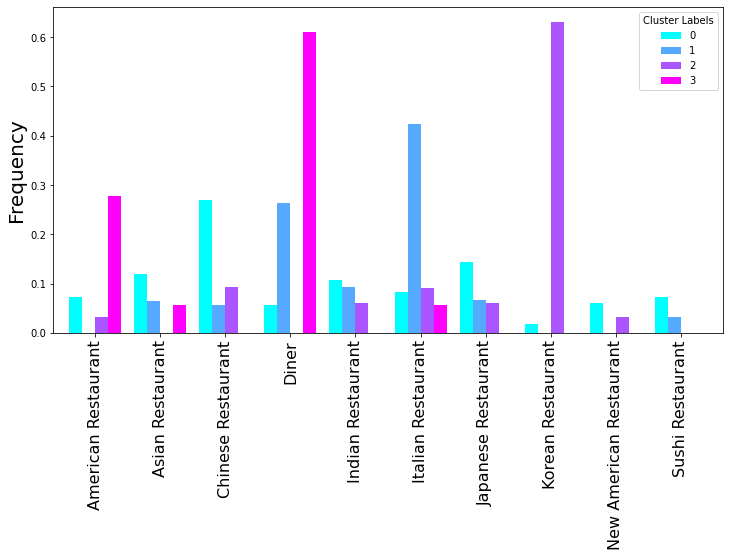

In [19]:
# plot bar graph to compare
cluster_means.plot(kind="bar", figsize=(12,6), 
                   width=0.8, color=rainbow)
plt.xticks(fontsize=16)
plt.ylabel('Frequency', fontsize=20)
plt.show()

So, it looks like...
* Cluster 0 has more Chinese and Japanese restaurants
* Cluster 1 has more Italian restaurants and Diners
* Cluster 2 has more Korean restaurants
* Cluster 3 has more American restaurants and Diners